In [ ]:
### please specify your input path here
PROJECT_FOLDER = "YOUR_PROJECT_FOLDER" # parent folder of the input images
IMAGE_DATA_FOLDER = PROJECT_FOLDER + "images/" # folder of the input images
INPUT_TEST_CSV_FILE = "YOUR_TEST_FILE" # csv file list locations / paths to test cases (dicom)
OUTPUT_FOLDER = PROJECT_FOLDER + "output/" # output folder for the GRADCAM images

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import scipy as sp
import os
import json
import sys
import importlib
import multiprocessing as mp
import gc
from tqdm.auto import tqdm
import glob
import torch
from copy import copy
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader
import timm
import pylibjpeg
import pydicom
from PIL import Image
import re
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gc.collect()

In [3]:
pd.__version__

'1.3.5'

In [4]:
torch.backends.cudnn.enabled = False

sys.path.append('./configs')
sys.path.append('./data')
sys.path.append('./models')
sys.path.append('./postprocess')
sys.path.append('./github-rsna2022')

In [ ]:
COMP_FOLDER = PROJECT_FOLDER
DATA_FOLDER = IMAGE_DATA_FOLDER
META_DF = INPUT_TEST_CSV_FILE

test_df = pd.read_csv(INPUT_TEST_CSV_FILE)#.iloc[:1]

print(test_df.head)

keycols = 'StudyInstanceUID slice_number'.split()

entries = []
for key, row in test_df.iterrows():
    image_index = [int(re.findall(r'-(\d+).d', i)[0]) for i in os.listdir(row['image_folder'])]
    for im_i in image_index:
        entries.append([row['StudyInstanceUID'], row['image_folder'], im_i])
    

df = pd.DataFrame(entries, columns = ['StudyInstanceUID', 'image_folder', 'slice_number'])
df['slice_number'] = df['slice_number'].astype(int)
df = df.sort_values(keycols).reset_index(drop = True)

N_CORES = mp.cpu_count()
MIXED_PRECISION = False
PIN_MEMORY = True
DL_PREFETCH_FACTOR = 1
NUM_SLICES_PER_UID_BBOX = 600

FOLD = 3
MAX_FOLDS = 99

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

df['StudyInstanceUID'] = df.StudyInstanceUID.astype('category')
df['fold'] = -1

print(test_df.shape)
print(df.shape)
gc.collect()
gc.collect()

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# change it to nn.BCELoss(reduction='none') if you have sigmoid activation in last layer
loss_fn = torch.nn.BCELoss(reduction="none") 
competition_weights = {
    '-' : torch.tensor([7, 1, 1, 1, 1, 1, 1, 1], dtype=torch.float, device=device),
    '+' : torch.tensor([14, 2, 2, 2, 2, 2, 2, 2], dtype=torch.float, device=device),
}

In [10]:
def get_cfg(CFG):
    cfg = importlib.import_module('default_config')
    importlib.reload(cfg)
    cfg = importlib.import_module(CFG)
    importlib.reload(cfg)
    cfg = copy(cfg.cfg)
    cfg.post_process_pipeline = importlib.import_module(cfg.post_process_pipeline).post_process_pipeline

    cfg.data_dir = COMP_FOLDER
    cfg.test_data_folder = DATA_FOLDER
    cfg.mixed_precision = MIXED_PRECISION
    cfg.pretrained = False
    cfg.pretrained_weights = False
    cfg.batch_size = cfg.batch_size
    cfg.offline_inference = True

    print(CFG, cfg.model, cfg.dataset, cfg.backbone, cfg.pretrained_weights, cfg.post_process_pipeline)
    
    return cfg

def get_dl(cfg):
    ds = importlib.import_module(cfg.dataset)
    importlib.reload(ds)

    CustomDataset = ds.CustomDataset
    batch_to_device = ds.batch_to_device

    test_ds = CustomDataset(df, cfg, cfg.val_aug, mode="test")
    test_dl = DataLoader(test_ds, shuffle=False, batch_size=cfg.batch_size, collate_fn=ds.val_collate_fn, num_workers=N_CORES, pin_memory=PIN_MEMORY, prefetch_factor = DL_PREFETCH_FACTOR)

    return test_dl, batch_to_device

def get_bb_dl(cfg):
    ds = importlib.import_module(cfg.dataset)
    importlib.reload(ds)

    CustomDataset = ds.CustomDataset
    batch_to_device = ds.batch_to_device

    test_ds = CustomDataset(bbdf, cfg, cfg.val_aug, mode="test")
    test_dl = DataLoader(test_ds, shuffle=False, batch_size=cfg.batch_size, collate_fn=ds.val_collate_fn, num_workers=N_CORES, pin_memory=PIN_MEMORY, prefetch_factor = DL_PREFETCH_FACTOR)

    return test_dl, batch_to_device

def get_state_dict(sd_fp):
    sd = torch.load(sd_fp, map_location="cpu")
    sd = {k.replace("module.", ""):v for k,v in sd.items()}
    return sd

def get_nets(cfg,state_dicts,test_ds):
    model = importlib.import_module(cfg.model)
    importlib.reload(model)
    Net = model.Net

    nets = []

    for i,state_dict in enumerate(state_dicts):
        net = Net(cfg).eval().to(DEVICE)
        print("loading dict")
        sd = get_state_dict(state_dict)
        if "model" in sd.keys():
            sd = sd["model"]
        net.load_state_dict(sd, strict=True)
        nets += [net.half()]
        del sd
        gc.collect()
    return nets

def competiton_loss_row_norm(y_hat, y):
    loss = loss_fn(y_hat, y)
    weights = y * competition_weights['+'] + (1 - y) * competition_weights['-']
    loss = (loss * weights).sum(axis=1)
    w_sum = weights.sum(axis=1)
    loss = torch.div(loss, w_sum)
    return loss.mean().item()

def window_range(g, thresh = 0.1, window = 5, min_periods=3, center=True):
    bbseqprobas = g.has_bbox.rolling(window, min_periods=min_periods, center=center).mean()
    if bbseqprobas.max() <= thresh:
        sn_from, sn_to = g.slice_numbers.iloc[[0,-1]]
        return [sn_from, sn_to]
    bb_range = np.where(bbseqprobas > thresh)[0]
    sn_from = g.slice_numbers.iloc[bb_range[0]]
    sn_to = g.slice_numbers.iloc[bb_range[-1]]
    return [sn_from, sn_to]

In [11]:
bbdf = df.copy()

In [ ]:
name = 'cfg_loc_dh_01B'

cfg = get_cfg(name)
cfg.meta_df = META_DF
cfg.data_folder = DATA_FOLDER
cfg.verify_sample = False
cfg.load_jpg = False
cfg.batch_size = 8
cfg.drop_scans = []
test_dl, batch_to_device = get_bb_dl(cfg)
state_dict_fps = sorted(glob.glob('./weights-cfg-loc-dh-01b-all-fold-1/fold*check*'))[:MAX_FOLDS]
print('\n'.join(state_dict_fps))
nets = get_nets(cfg,state_dict_fps, test_dl.dataset)

In [13]:
val_data = {}
preds = []
uids = []
slices = []
#ids = []
with torch.inference_mode():
    for tt, batch in tqdm(enumerate(test_dl), total = len(test_dl)):
        batch = batch_to_device(batch,DEVICE)
        batch['image'] = batch['image'].half()
        outs = [net(batch) for net in nets]
        preds += [torch.stack([out['preds'] for out in outs], dim=0).cpu().mean(0)]
        uids +=  [outs[0]['StudyUID'].cpu()]
        slices += [outs[0]['slice_numbers'].cpu()]
        if tt % 5 == 0:
            gc.collect()
            torch.cuda.empty_cache()
        #ids += batch['StudyUID'].cpu()
preds = torch.cat(preds, dim=0)
uids = torch.cat(uids, dim=0)
slices = torch.cat(slices, dim=0)


100%|██████████| 1420/1420 [02:03<00:00, 11.46it/s]


In [14]:
predbbdf = pd.DataFrame(preds.float().clip(0, 1).numpy(), columns = 'x0 y0 x1 y1 has_bbox'.split())
predbbdf['uid'] = uids.numpy()
predbbdf['slice_numbers'] = slices.numpy()[:,1]
predbbdf['slice_numbers_all'] = slices.numpy().tolist()
predbbdf['StudyInstanceUID'] = test_dl.dataset.df.loc[test_dl.dataset.ids]['StudyInstanceUID'].values
predbbdf['StudyInstanceUID'] = predbbdf['StudyInstanceUID'].astype('category')

<Axes: >

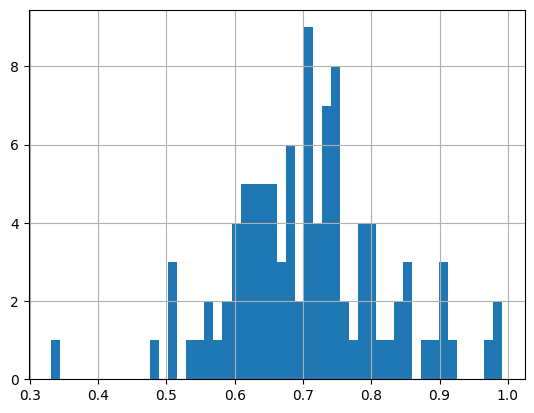

In [15]:
allpreddf = predbbdf
allpreddf = allpreddf.explode('slice_numbers_all')
allpreddf['slice_numbers'] = allpreddf['slice_numbers_all']
allpreddf = allpreddf.set_index('StudyInstanceUID').drop(['slice_numbers_all', 'uid'], axis=1)

allpreddf.to_csv('train_bbox_all_pred_v02.csv')

# Hack for studies with no bounding box > 0.5.... - just put in a dummy box and let it go thru the pipeline
predbbdf['max_has_bbox'] = predbbdf.groupby('StudyInstanceUID')['has_bbox'].transform(max)
predbbdf.loc[predbbdf.max_has_bbox<0.5, 'x0 y0'.split()] = 0.2
predbbdf.loc[predbbdf.max_has_bbox<0.5, 'x1 y1'.split()] = 0.8
predbbdf.loc[predbbdf.max_has_bbox<0.5, 'has_bbox'.split()] = 0.51
predbbdf = predbbdf.drop('max_has_bbox', axis=1)

bbpreddf = pd.concat([ \
    predbbdf.query('has_bbox > 0.5').groupby('StudyInstanceUID')['x0 y0'.split()].apply(min),
    predbbdf.query('has_bbox > 0.5').groupby('StudyInstanceUID')['x1 y1'.split()].apply(max)], axis=1)

wrls = predbbdf.groupby('StudyInstanceUID').apply(window_range)
wrdf = pd.DataFrame(wrls.tolist(), index = wrls.index, columns = 'slnum_from slnum_to'.split())
bbpreddf['slnum_from slnum_to'.split()] = wrdf.loc[bbpreddf.index]
bbpreddf['slnum_max'] = predbbdf.groupby('StudyInstanceUID')['slice_numbers'].max().loc[bbpreddf.index]

bbpreddf.iloc[:,:2] = np.floor((bbpreddf.iloc[:,:2] * 512)).astype(int).clip(0, 512)
bbpreddf.iloc[:,2:4] = np.ceil((bbpreddf.iloc[:,2:4] * 512)).astype(int).clip(0, 512)
bbpreddf.to_csv('train_bbox_pred_v01.csv')

((bbpreddf.slnum_to - bbpreddf.slnum_from) / bbpreddf.slnum_max).hist(bins = 50 )

In [16]:
del test_dl, nets, preds, uids, slices, predbbdf, bbpreddf, allpreddf
gc.collect()
torch.cuda.empty_cache()

In [17]:
!head train_bbox_pred_v01.csv

StudyInstanceUID,x0,y0,x1,y1,slnum_from,slnum_to,slnum_max
1.2.826.0.1.3680043.10.474.634358.1013806,72,116,416,479,24,291,393
1.2.826.0.1.3680043.10.474.634358.1023781,111,45,349,282,134,299,323
1.2.826.0.1.3680043.10.474.634358.1025516,91,80,425,401,51,249,309
1.2.826.0.1.3680043.10.474.634358.1035182,79,52,406,353,117,354,354
1.2.826.0.1.3680043.10.474.634358.1045219,119,133,405,453,74,248,320
1.2.826.0.1.3680043.10.474.634358.1051367,96,99,382,358,47,317,359
1.2.826.0.1.3680043.10.474.634358.1053117,104,138,415,474,86,266,308
1.2.826.0.1.3680043.10.474.634358.1056078,121,100,448,443,3,297,321
1.2.826.0.1.3680043.10.474.634358.1059270,72,40,434,427,50,272,332


In [18]:
!head train_bbox_all_pred_v02.csv

StudyInstanceUID,x0,y0,x1,y1,has_bbox,slice_numbers
1.2.826.0.1.3680043.10.474.634358.1013806,0.2919922,0.22692871,0.4951172,0.5175781,0.041931152,2
1.2.826.0.1.3680043.10.474.634358.1013806,0.2919922,0.22692871,0.4951172,0.5175781,0.041931152,3
1.2.826.0.1.3680043.10.474.634358.1013806,0.2919922,0.22692871,0.4951172,0.5175781,0.041931152,4
1.2.826.0.1.3680043.10.474.634358.1013806,0.30151367,0.23498535,0.5839844,0.54589844,0.03326416,5
1.2.826.0.1.3680043.10.474.634358.1013806,0.30151367,0.23498535,0.5839844,0.54589844,0.03326416,6
1.2.826.0.1.3680043.10.474.634358.1013806,0.30151367,0.23498535,0.5839844,0.54589844,0.03326416,7
1.2.826.0.1.3680043.10.474.634358.1013806,0.3100586,0.25024414,0.5683594,0.4729004,0.045288086,8
1.2.826.0.1.3680043.10.474.634358.1013806,0.3100586,0.25024414,0.5683594,0.4729004,0.045288086,9
1.2.826.0.1.3680043.10.474.634358.1013806,0.3100586,0.25024414,0.5683594,0.4729004,0.045288086,10


## GRAD CAM starts here

In [21]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import BinaryClassifierOutputTarget
import cv2

output_folder = OUTPUT_FOLDER
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
targets = [BinaryClassifierOutputTarget(1)] # BinaryClassifierOutputTarget

In [22]:
def cam_to_voxel_space_3q(cam: np.ndarray, shape_, cropping_coords, slice_index) -> np.ndarray:
    depth, h, w = shape_
    assert cam.shape[0] == len(cropping_coords), f"Size should match cam.shape[0]:{cam.shape[0]}, cropping coords: {len(cropping_coords)}"
    
    length = len(slice_index)
    
    grayscale_cam_resized = np.zeros((depth, h, w))
    
    cam_length = cam.shape[0]
    frame_interval = cam_length / length
    max_index = cam_length - 1
    
    offset_index = int((length - max_index * length / cam_length) / 2)
    
    for i in range(offset_index):
        x0, y0, x1, y1 = cropping_coords[i]
        resized_ind = slice_index[i] - 2
        w, h = x1-x0, y1-y0
        grayscale_cam_resized[resized_ind, y0:y1, x0:x1] = cv2.resize(cam[i], (w, h)) * 0.667
        
        x0, y0, x1, y1 = cropping_coords[cam_length - i - 1]
        resized_ind = slice_index[length - i - 1] - 2
        w, h = x1-x0, y1-y0
        grayscale_cam_resized[resized_ind, y0:y1, x0:x1] = cv2.resize(cam[cam_length - i - 1], (w, h)) * 0.667
        
    for j in range(offset_index, length - offset_index):
        resized_ind = slice_index[j] - 2
        ind = j - offset_index
        idx1 = int(ind * frame_interval)
        idx2 = min(idx1 + 1, max_index)
        alpha = (ind * frame_interval) - idx1

        cam1 = cam[idx1]
        x10, y10, x11, y11 = cropping_coords[idx1]
        w1, h1 = x11-x10, y11-y10
        
        cam2 = cam[idx2]
        x20, y20, x21, y21 = cropping_coords[idx2]
        w2, h2 = x21-x20, y21-y20
        
        temp_cam = cv2.addWeighted(cam1, 1 - alpha, cam2, alpha, 0)
        
        w, h = int((w1 + w2) / 2), int((h1 + h2) / 2)
        x, y = int((x10 + x20) / 2), int((y10 + y20) / 2)
        
        temp_cam_resized = cv2.resize(temp_cam, (w, h))
        grayscale_cam_resized[resized_ind, y:y+h, x:x+w] = temp_cam_resized

    return grayscale_cam_resized


In [23]:
import SimpleITK as sitk
import warnings

def read_from_DICOM_dir(DICOM_dir, dtype=sitk.sitkInt16):
    reader = sitk.ImageSeriesReader()
    list_series_ids = reader.GetGDCMSeriesIDs(DICOM_dir)

    sum_series = len(list_series_ids)
    if sum_series > 1:
        warnings.warn('Multiple series ids in this dir, only read one series')

    series_uid = list_series_ids[0]
    file_names = reader.GetGDCMSeriesFileNames(DICOM_dir, series_uid)
    image_nii = sitk.ReadImage(file_names, dtype)

    return image_nii

In [ ]:
name = 'cfg_dh_fracseq_04F_crop3_gx1_cam'

cfg = get_cfg(name)
cfg.meta_df = META_DF
cfg.data_folder = DATA_FOLDER
cfg.verify_sample = False
cfg.load_jpg = False
cfg.cnn_chunk_size = 32
cfg.bbox_df = 'train_bbox_pred_v01.csv'  #. f'{cfg.data_dir}/train_bbox_pred_v02.csv.gz'
cfg.bboxall_df = 'train_bbox_all_pred_v02.csv' # f'{cfg.data_dir}/train_bbox_all_pred_v02.csv.gz'
# cfg.bbox_df = 'train_bbox_pred_v01.csv'
# cfg.bbox_df = 'train_bbox_all_pred_v02.csv'

cfg.batch_size=1
#cfg.dataset = "ds_dh_fracseg_3F_crop_infer"
cfg.norm_on_cuda=True
test_dl, batch_to_device = get_dl(cfg)
test_dl.dataset.norm_mean = test_dl.dataset.norm_mean.to(DEVICE)#.half()
test_dl.dataset.norm_std = test_dl.dataset.norm_std.to(DEVICE)#.half()
#test_dl.dataset.df[cfg.target_seg] = 0.
#test_dl.dataset.df[cfg.target_frac] = 0.
test_dl.dataset.metadf = pd.DataFrame({'StudyInstanceUID': \
                                       test_dl.dataset.df.index.unique()}).set_index('StudyInstanceUID')
test_dl.dataset.metadf[['patient_overall'] + cfg.target] = 0.
#test_dl.dataset.metadf

state_dict_fps = sorted(glob.glob('./weights-cfg-dh-fracseq-04f-crop3-gx1-4f3ff/fold-1*check*'))
if OOF_CHECK:
    state_dict_fps = [i for i in state_dict_fps if f'fold{FOLD}_' in i]
state_dict_fps = state_dict_fps[:]

print('\n'.join(state_dict_fps))
if OOF_CHECK:
    nets = get_nets(cfg,state_dict_fps[:1], test_dl.dataset)
else:
    nets = get_nets(cfg,state_dict_fps, test_dl.dataset)

In [ ]:
vaacoshl_data = {}
preds = []
#ids = []/
torch.set_grad_enabled(True)

target_layers = [net.backbone.layer4 for net in nets]

for tt, batch in tqdm(enumerate(test_dl), total = len(test_dl)):
    batch = batch_to_device(batch,DEVICE)
    img = test_dl.dataset.norm4d(batch['image'])
    gray_cam = None
    for index, net in enumerate(nets):
        with GradCAM(model=net, target_layers=[target_layers[index]], use_cuda=torch.cuda.is_available()) as cam:
            if gray_cam is None:
                gray_cam = cam(input_tensor=img, targets=targets)
            else:
                gray_cam += cam(input_tensor=img, targets=targets)
    
    # gray_cam /= 3
    
    local_df = test_df[test_df['StudyInstanceUID'].str.contains(str(batch['StudyUID'].item()))].iloc[0]
    
    nii_image = read_from_DICOM_dir(local_df['image_folder'])
    nd_image = sitk.GetArrayFromImage(nii_image)
    resized_cam = cam_to_voxel_space_3q(gray_cam, nd_image.shape, batch['transformations'][0]['cropping_coords'], batch['transformations'][0]['slice_numbers'])
    
    # Define the file path for saving
    save_path = os.path.join(output_folder, f"{local_df['StudyInstanceUID']}.1.npy")

    # Save the resized_cam as a .npy file
    np.save(save_path, resized_cam)
    
    if tt % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

del test_dl, nets
gc.collect()
torch.cuda.empty_cache()

In [28]:
name = 'cfg_dh_fracseq_04F_crop_gx1_cam'

cfg = get_cfg(name)
cfg.meta_df = META_DF
cfg.data_folder = DATA_FOLDER
cfg.verify_sample = False
cfg.load_jpg = False
cfg.cnn_chunk_size = 32
cfg.bbox_df = 'train_bbox_pred_v01.csv'
cfg.batch_size=1
cfg.norm_on_cuda=True
test_dl, batch_to_device = get_dl(cfg)
test_dl.dataset.norm_mean = test_dl.dataset.norm_mean.to(DEVICE)
test_dl.dataset.norm_std = test_dl.dataset.norm_std.to(DEVICE)
test_dl.dataset.metadf = pd.DataFrame({'StudyInstanceUID': \
                                       test_dl.dataset.df.index.unique()}).set_index('StudyInstanceUID')
test_dl.dataset.metadf[['patient_overall'] + cfg.target] = 0.

state_dict_fps = sorted(glob.glob('./weights-cfg-dh-fracseq-04f-crop-gx1-6ff/fold-1*check*'))
if OOF_CHECK:
    state_dict_fps = [i for i in state_dict_fps if f'fold{FOLD}_' in i]
state_dict_fps = state_dict_fps[:MAX_FOLDS]

print('\n'.join(state_dict_fps))
nets = get_nets(cfg,state_dict_fps, test_dl.dataset)

cfg_dh_fracseq_04F_crop_gx1_cam mdl_dh_seg_3G_gx1_cam ds_dh_fracseg_3I_crop resnest50d False <function post_process_pipeline at 0x7ff23ab7b9d0>
./weights-cfg-dh-fracseq-04f-crop-gx1-6ff/fold-1___checkpoint_last_seed142436.pth
./weights-cfg-dh-fracseq-04f-crop-gx1-6ff/fold-1___checkpoint_last_seed294085.pth
./weights-cfg-dh-fracseq-04f-crop-gx1-6ff/fold-1___checkpoint_last_seed682885.pth
loading dict
loading dict
loading dict


In [ ]:
name = 'cfg_dh_fracseq_04F_crop_gx2_cam'

cfg = get_cfg(name)
cfg.meta_df = META_DF
cfg.data_folder = DATA_FOLDER
cfg.verify_sample = False
cfg.load_jpg = False
cfg.cnn_chunk_size = 32
cfg.bbox_df = 'train_bbox_pred_v01.csv'
cfg.batch_size=1
#cfg.dataset = "ds_dh_fracseg_3F_crop_infer"
cfg.norm_on_cuda=True
test_dl, batch_to_device = get_dl(cfg)
test_dl.dataset.norm_mean = test_dl.dataset.norm_mean.to(DEVICE)#.half()
test_dl.dataset.norm_std = test_dl.dataset.norm_std.to(DEVICE)#.half()
#test_dl.dataset.df[cfg.target_seg] = 0.
#test_dl.dataset.df[cfg.target_frac] = 0.
test_dl.dataset.metadf = pd.DataFrame({'StudyInstanceUID': \
                                       test_dl.dataset.df.index.unique()}).set_index('StudyInstanceUID')
test_dl.dataset.metadf[['patient_overall'] + cfg.target] = 0.
#test_dl.dataset.metadf

state_dict_fps = sorted(glob.glob('./weights-cfg-dh-fracseq-04f-crop-gx2-4f2ff/fold-1*check*'))
state_dict_fps = state_dict_fps[:MAX_FOLDS]

print('\n'.join(state_dict_fps))
nets += get_nets(cfg,state_dict_fps, test_dl.dataset)

In [ ]:
name = 'cfg_dh_fracseq_04G_crop_gx1_cam'

cfg = get_cfg(name)
cfg.meta_df = META_DF
cfg.data_folder = DATA_FOLDER
cfg.verify_sample = False
cfg.load_jpg = False
cfg.cnn_chunk_size = 16
cfg.bbox_df = 'train_bbox_pred_v01.csv'
cfg.batch_size=1
cfg.norm_on_cuda=True
test_dl, batch_to_device = get_dl(cfg)
test_dl.dataset.norm_mean = test_dl.dataset.norm_mean.to(DEVICE)#.half()
test_dl.dataset.norm_std = test_dl.dataset.norm_std.to(DEVICE)#.half()
test_dl.dataset.metadf = pd.DataFrame({'StudyInstanceUID': \
                                       test_dl.dataset.df.index.unique()}).set_index('StudyInstanceUID')
test_dl.dataset.metadf[['patient_overall'] + cfg.target] = 0.
state_dict_fps = sorted(glob.glob('./weights-cfg-dh-fracseq-04g-crop-gx1-5f2ff/fold-1*check*'))
state_dict_fps = state_dict_fps[:MAX_FOLDS]

print('\n'.join(state_dict_fps))
nets += get_nets(cfg,state_dict_fps, test_dl.dataset)

In [31]:
print(len(nets))
print('Cnn chunk sizes : '+' '.join(map(str, [i.cfg.cnn_chunk_size for i in nets])))

10
Cnn chunk sizes : 32 32 32 32 32 32 16 16 16 16


In [ ]:
vaacoshl_data = {}
preds = []
#ids = []
target_layers = [net.backbone.layer4 for net in nets]
for tt, batch in tqdm(enumerate(test_dl), total = len(test_dl)):
    batch = batch_to_device(batch,DEVICE)
    img = test_dl.dataset.norm4d(batch['image'])
    gray_cam = None
    for index, net in enumerate(nets):
        with GradCAM(model=net, target_layers=[target_layers[index]], use_cuda=torch.cuda.is_available()) as cam:
            if gray_cam is None:
                gray_cam = cam(input_tensor=img, targets=targets)
            else:
                gray_cam += cam(input_tensor=img, targets=targets)
    
    local_df = test_df[test_df['StudyInstanceUID'].str.contains(str(batch['StudyUID'].item()))].iloc[0]
    
    nii_image = read_from_DICOM_dir(local_df['image_folder'])
    nd_image = sitk.GetArrayFromImage(nii_image)
    resized_cam = cam_to_voxel_space_3q(gray_cam, nd_image.shape, batch['transformations'][0]['cropping_coords'], batch['transformations'][0]['slice_numbers'])
    
    # Define the file path for saving
    save_path = os.path.join(output_folder, f"{local_df['StudyInstanceUID']}.2.npy")

    # Save the resized_cam as a .npy file
    np.save(save_path, resized_cam)

    if tt % 10 == 0:
        gc.collect()
        torch.cuda.empty_cache()

del test_dl, nets
gc.collect()
torch.cuda.empty_cache()